# Alpha Factor Library

This notebook contains a mumber of alpha factor candidates that we can use as features in ML models on the Quantopian platform.

In [1]:
import pandas as pd
import numpy as np
from time import time
# import talib
import re
from statsmodels.api import OLS
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.preprocessing import StandardScaler

from zipline.research import run_pipeline
from zipline.pipeline import Pipeline, factors, filters, classifiers, EquityPricing
# from zipline.pipeline.data.builtin import USEquityPricing
from zipline.pipeline.factors import (Latest, 
                                         Returns, 
                                         AverageDollarVolume, 
                                         SimpleMovingAverage,
                                         EWMA,
                                         BollingerBands,
                                         CustomFactor,
                                        #  MarketCap,
                                        SimpleBeta)
from zipline.pipeline.filters import StaticAssets #QTradableStocksUS, 
# from zipline.pipeline.data.quandl import fred_usdontd156n as libor
from empyrical import max_drawdown, sortino_ratio



import seaborn as sns
import matplotlib.pyplot as plt


###
import talib
###

## Data Sources

In [2]:
# ################
# # Fundamentals #
# ################

# # Morningstar fundamentals (2002 - Ongoing)
# # https://www.quantopian.com/help/fundamentals
# from quantopian.pipeline.data import Fundamentals
from zipline.research import sid
from zipline.pipeline import sharadar
art_fundamentals = sharadar.Fundamentals.slice('ART', period_offset=0)


# #####################
# # Analyst Estimates #
# #####################

# # Earnings Surprises - Zacks (27 May 2006 - Ongoing)
# # https://www.quantopian.com/data/zacks/earnings_surprises
# from quantopian.pipeline.data.zacks import EarningsSurprises
# from quantopian.pipeline.factors.zacks import BusinessDaysSinceEarningsSurprisesAnnouncement

# ##########
# # Events #
# ##########

# # Buyback Announcements - EventVestor (01 Jun 2007 - Ongoing)
# # https://www.quantopian.com/data/eventvestor/buyback_auth
# from quantopian.pipeline.data.eventvestor import BuybackAuthorizations
# from quantopian.pipeline.factors.eventvestor import BusinessDaysSinceBuybackAuth

# # CEO Changes - EventVestor (01 Jan 2007 - Ongoing)
# # https://www.quantopian.com/data/eventvestor/ceo_change
# from quantopian.pipeline.data.eventvestor import CEOChangeAnnouncements

# # Dividends - EventVestor (01 Jan 2007 - Ongoing)
# # https://www.quantopian.com/data/eventvestor/dividends
# from quantopian.pipeline.data.eventvestor import (
#     DividendsByExDate,
#     DividendsByPayDate,
#     DividendsByAnnouncementDate,
# )
# from quantopian.pipeline.factors.eventvestor import (
#     BusinessDaysSincePreviousExDate,
#     BusinessDaysUntilNextExDate,
#     BusinessDaysSinceDividendAnnouncement,
# )

# # Earnings Calendar - EventVestor (01 Jan 2007 - Ongoing)
# # https://www.quantopian.com/data/eventvestor/earnings_calendar
# from quantopian.pipeline.data.eventvestor import EarningsCalendar
# from quantopian.pipeline.factors.eventvestor import (
#     BusinessDaysUntilNextEarnings,
#     BusinessDaysSincePreviousEarnings
# )

# # 13D Filings - EventVestor (01 Jan 2007 - Ongoing)
# # https://www.quantopian.com/data/eventvestor/_13d_filings
# from quantopian.pipeline.data.eventvestor import _13DFilings
# from quantopian.pipeline.factors.eventvestor import BusinessDaysSince13DFilingsDate

# #############
# # Sentiment #
# #############

# # News Sentiment - Sentdex Sentiment Analysis (15 Oct 2012 - Ongoing)
# # https://www.quantopian.com/data/sentdex/sentiment
# from quantopian.pipeline.data.sentdex import sentiment

### Setup

In [3]:
# trading days per period
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2023-07-20'
END = '2023-09-20'

#### Universe

In [5]:
from zipline.pipeline import Pipeline, EquityPricing, master
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.research import run_pipeline

from codeload.pipeline_tutorial.tradable_stocks import TradableStocksUS

In [6]:
# UNIVERSE = StaticAssets(symbols(['MSFT', 'AAPL']))
# UNIVERSE = Q100US()
UNIVERSE = TradableStocksUS(True) #& sharadar.SP500.in_sp500.latest

In [7]:
# def Q100US():
#     universe = tradable_stocks_us_universe
#     return filters.make_us_equity_universe(
#         target_size=100,
#         rankby=factors.AverageDollarVolume(window_length=200),
#         mask=tradable_stocks_us_universe,
#         groupby=classifiers.fundamentals.Sector(),
#         max_group_weight=0.3,
#         smoothing_func=lambda f: f.downsample('month_start'),
#     )

In [8]:
def make_pipeline():
    
    
    # in_sp500 = sharadar.SP500.in_sp500.latest
    universe = UNIVERSE 
    
    
    # 10-day close price average.
    mean_10 = SimpleMovingAverage(inputs=EquityPricing.close, window_length=10, mask=universe)

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(inputs=EquityPricing.close, window_length=30, mask=universe)

    # Percent difference factor.
    percent_difference = (mean_10 - mean_30) / mean_30
        
    return Pipeline(
        columns={
            'percent_difference': percent_difference,
            'sector': master.SecuritiesMaster.usstock_Sector.latest
        },
        screen=universe
    )

In [9]:
result = run_pipeline(make_pipeline(), start_date='2015-05-05', end_date='2015-05-05')
result

percent_difference  \
date                      asset                                               
2015-05-05 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])               0.000209   
                          Equity(FIBBG005P7Q881 [AAL])             0.008126   
                          Equity(FIBBG000D9V7T4 [PRG])             0.095343   
                          Equity(FIBBG000C2LZP3 [AAON])            0.016510   
                          Equity(FIBBG000F7RCJ1 [AAP])            -0.010067   
...                                                                     ...   
                          Equity(FIBBG0064MY238 [ZOES])           -0.006636   
                          Equity(FIBBG003LFL2G1 [ZSPH])           -0.032424   
                          Equity(FIBBG0039320N9 [ZTS])            -0.006146   
                          Equity(FIBBG001Z7M393 [ZU])             -0.043705   
                          Equity(FIBBG000PYX812 [ZUMZ])           -0.082763   

                                                                         sector  
date                      asset                                                  
2015-05-05 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])                 Technology  
                          Equity(FIBBG005P7Q881 [AAL])              Industrials  
                          Equity(FIBBG000D9V7T4 [PRG])              Industrials  
                          Equity(FIBBG000C2LZP3 [AAON])               Materials  
                          Equity(FIBBG000F7RCJ1 [AAP])   Consumer Discretionary  
...                                                                         ...  
                          Equity(FIBBG0064MY238 [ZOES])  Consumer Discretionary  
                          Equity(FIBBG003LFL2G1 [ZSPH])             Health Care  
                          Equity(FIBBG0039320N9 [ZTS])              Health Care  
                          Equity(FIBBG001Z7M393 [ZU])    Consumer Discretionary  
                          Equity(FIBBG000PYX812 [ZUMZ])  Consumer Discretionary  

[1984 rows x 2 columns]

In [10]:
# class AnnualizedData(CustomFactor):
#     # Get the sum of the last 4 reported values
#     window_length = 260

#     def compute(self, today, assets, out, asof_date, values):
#         for asset in range(len(assets)):
#             # unique asof dates indicate availability of new figures
#             _, filing_dates = np.unique(asof_date[:, asset], return_index=True)
#             quarterly_values = values[filing_dates[-4:], asset]
#             # ignore annual windows with <4 quarterly data points
#             if len(~np.isnan(quarterly_values)) != 4:    
#                 out[asset] = np.nan
#             else:
#                 out[asset] = np.sum(quarterly_values)

In [11]:
# class AnnualAvg(CustomFactor):
#     window_length = 252
    
#     def compute(self, today, assets, out, values):
#         out[:] = (values[0] + values[-1])/2

In [12]:
def factor_pipeline(factors):
    start = time()
    pipe = Pipeline({k: v(mask=UNIVERSE).rank() for k, v in factors.items()},
                    screen=UNIVERSE)
    result = run_pipeline(pipe, start_date=START, end_date=END)
    return result, time() - start

### Value Factors

In [13]:
class ValueFactors:
    """Definitions of factors for cross-sectional trading algorithms"""
    
    @staticmethod
    def PriceToSalesTTM(**kwargs):
        """Last closing price divided by sales per share"""    
        return art_fundamentals.PS.latest
        # return Fundamentals.ps_ratio.latest

    @staticmethod
    def PriceToEarningsTTM(**kwargs):
        """Closing price divided by earnings per share (EPS)"""
        return art_fundamentals.PE.latest
        # return Fundamentals.pe_ratio.latest
 
    @staticmethod
    def PriceToDilutedEarningsTTM(mask):
        """Closing price divided by diluted EPS"""
        last_close = EquityPricing.close.latest
        diluted_eps = art_fundamentals.EPSDIL.latest        
        # diluted_eps = AnnualizedData(inputs = [Fundamentals.diluted_eps_earnings_reports_asof_date,
        #                                        Fundamentals.diluted_eps_earnings_reports],
        #                              mask=mask)  
        output = last_close / diluted_eps
        # if mask is not None:
        #     output = output.where(mask)      
        return output

    # @staticmethod
    # def PriceToForwardEarnings(**kwargs):
    #     """Price to Forward Earnings"""
    #     return sharadar.Fundamentals.slice(dimension="ART").???.latest
    
    @staticmethod
    def DividendYield(**kwargs):
        """Dividends per share divided by closing price"""
        # return Fundamentals.trailing_dividend_yield.latest
        return art_fundamentals.DIVYIELD.latest

    @staticmethod
    def PriceToFCF(mask):
        """Price to Free Cash Flow"""
        # last_close = EquityPricing.close.latest
        # fcf_share = AnnualizedData(inputs = [Fundamentals.fcf_per_share_asof_date,
        #                                      Fundamentals.fcf_per_share],
        #                            mask=mask)
        # return last_close / fcf_share
        return art_fundamentals.FCFPS.latest
        

    @staticmethod
    def PriceToOperatingCashflow(mask):
        """Last Close divided by Operating Cash Flows"""
        last_close = EquityPricing.close.latest
        # cfo_per_share = AnnualizedData(inputs = [Fundamentals.cfo_per_share_asof_date,
        #                                          Fundamentals.cfo_per_share],
        #                                mask=mask)        
        cfo_per_share = art_fundamentals.NCFO.latest
        return last_close / cfo_per_share

    @staticmethod
    def PriceToBook(mask):
        """Closing price divided by book value"""
        # last_close = EquityPricing.close.latest
        # book_value_per_share = AnnualizedData(inputs = [Fundamentals.book_value_per_share_asof_date,
        #                                       Fundamentals.book_value_per_share],
        #                                      mask=mask)        
        # return last_close / book_value_per_share
        return art_fundamentals.PB.latest 


    @staticmethod
    def EVToFCF(mask):
        # """Enterprise Value divided by Free Cash Flows"""
        # fcf = AnnualizedData(inputs = [Fundamentals.free_cash_flow_asof_date,
        #                                Fundamentals.free_cash_flow],
        #                      mask=mask)
        # return Fundamentals.enterprise_value.latest / fcf
        ev = art_fundamentals.EV.latest 
        fcf = art_fundamentals.FCF.latest 
        return ev / fcf

    @staticmethod
    def EVToEBITDA(mask):
        """Enterprise Value to Earnings Before Interest, Taxes, Deprecation and Amortization (EBITDA)"""
#         ebitda = AnnualizedData(inputs = [Fundamentals.ebitda_asof_date,
#                                           Fundamentals.ebitda],
#                                 mask=mask)

#         return Fundamentals.enterprise_value.latest / ebitda
        return art_fundamentals.EVEBITDA.latest 

    @staticmethod
    def EBITDAYield(mask):
        """EBITDA divided by latest close"""
        # ebitda = AnnualizedData(inputs = [Fundamentals.ebitda_asof_date,
        #                                   Fundamentals.ebitda],
        #                         mask=mask)
        ebitda = art_fundamentals.EBITDA.latest  
        return EquityPricing.close.latest / ebitda

In [14]:
VALUE_FACTORS = {
    'DividendYield'            : ValueFactors.DividendYield,
    'EBITDAYield'              : ValueFactors.EBITDAYield,
    'EVToEBITDA'               : ValueFactors.EVToEBITDA,
    'EVToFCF'                  : ValueFactors.EVToFCF,
    'PriceToBook'              : ValueFactors.PriceToBook,
    'PriceToDilutedEarningsTTM': ValueFactors.PriceToDilutedEarningsTTM,
    'PriceToFCF'               : ValueFactors.PriceToFCF,
    # 'PriceToForwardEarnings'   : ValueFactors.PriceToForwardEarnings,
    'PriceToOperatingCashflow' : ValueFactors.PriceToOperatingCashflow,
    'PriceToEarningsTTM'       : ValueFactors.PriceToEarningsTTM,
    'PriceToSalesTTM'          : ValueFactors.PriceToSalesTTM,
}

In [15]:
value_result, t = factor_pipeline(VALUE_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
value_result.info()

Pipeline run time 45.75 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DividendYield              92424 non-null  float64
 1   EBITDAYield                92380 non-null  float64
 2   EVToEBITDA                 92380 non-null  float64
 3   EVToFCF                    92380 non-null  float64
 4   PriceToBook                92424 non-null  float64
 5   PriceToDilutedEarningsTTM  92280 non-null  float64
 6   PriceToFCF                 92380 non-null  float64
 7   PriceToOperatingCashflow   92380 non-null  float64
 8   PriceToEarningsTTM         92424 non-null  float64
 9   PriceToSalesTTM            90908 non-null  float64
dtypes: float64(10)


### Momentum

In [16]:
from zipline.pipeline.factors import RSI, RollingLinearRegressionOfReturns


class MomentumFactors:
    """Custom Momentum Factors"""
    class PercentAboveLow(CustomFactor):
        """Percentage of current close above low 
        in lookback window of window_length days
        """
        inputs = [EquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            out[:] = close[-1] / np.min(close, axis=0) - 1

    class PercentBelowHigh(CustomFactor):
        """Percentage of current close below high 
        in lookback window of window_length days
        """
        
        inputs = [EquityPricing.close]
        window_length = 252
            
        def compute(self, today, assets, out, close):
            out[:] = close[-1] / np.max(close, axis=0) - 1

    @staticmethod
    def make_dx(timeperiod=14):
        class DX(CustomFactor):
            """Directional Movement Index"""
            inputs = [EquityPricing.high, 
                      EquityPricing.low, 
                      EquityPricing.close]
            window_length = timeperiod + 1
            
            def compute(self, today, assets, out, high, low, close):
                out[:] = [talib.DX(high[:, i], 
                                   low[:, i], 
                                   close[:, i], 
                                   timeperiod=timeperiod)[-1] 
                          for i in range(len(assets))]
        return DX  

    @staticmethod
    def make_mfi(timeperiod=14):
        class MFI(CustomFactor):
            """Money Flow Index"""
            inputs = [EquityPricing.high, 
                      EquityPricing.low, 
                      EquityPricing.close,
                      EquityPricing.volume]
            window_length = timeperiod + 1
            
            def compute(self, today, assets, out, high, low, close, vol):
                out[:] = [talib.MFI(high[:, i], 
                                    low[:, i], 
                                    close[:, i],
                                    vol[:, i],
                                    timeperiod=timeperiod)[-1] 
                          for i in range(len(assets))]
        return MFI           

    @staticmethod
    def make_oscillator(fastperiod=12, slowperiod=26, matype=0):
        class PPO(CustomFactor):
            """12/26-Day Percent Price Oscillator"""
            inputs = [EquityPricing.close]
            window_length = slowperiod

            def compute(self, today, assets, out, close_prices):
                out[:] = [talib.PPO(close,
                                    fastperiod=fastperiod,
                                    slowperiod=slowperiod, 
                                    matype=matype)[-1]
                         for close in close_prices.T]
        return PPO

    # @staticmethod
    # def make_stochastic_oscillator(fastk_period=5, slowk_period=3, slowd_period=3, 
    #                                slowk_matype=0, slowd_matype=0):                
    #     class StochasticOscillator(CustomFactor):
    #         """20-day Stochastic Oscillator """
    #         inputs = [EquityPricing.high, 
    #                   EquityPricing.low, 
    #                   EquityPricing.close]
    #         outputs = ['slowk', 'slowd']
    #         window_length = fastk_period * 2
            
    #         def compute(self, today, assets, out, high, low, close):
    #             slowk, slowd = [talib.STOCH(high[:, i],
    #                                         low[:, i],
    #                                         close[:, i], 
    #                                         fastk_period=fastk_period,
    #                                         slowk_period=slowk_period, 
    #                                         slowk_matype=slowk_matype, 
    #                                         slowd_period=slowd_period, 
    #                                         slowd_matype=slowd_matype)[-1] 
    #                             for i in range(len(assets))]

    #             out.slowk[:], out.slowd[:] = slowk[-1], slowd[-1]
    #     return StochasticOscillator
    
    @staticmethod
    def make_trendline(timeperiod=252):                
        class Trendline(CustomFactor):
            inputs = [EquityPricing.close]
            """52-Week Trendline"""
            window_length = timeperiod

            def compute(self, today, assets, out, close_prices):
                out[:] = [talib.LINEARREG_SLOPE(close, 
                                   timeperiod=timeperiod)[-1] 
                          for close in close_prices.T]
        return Trendline

In [17]:
MOMENTUM_FACTORS = {
    'Percent Above Low'            : MomentumFactors.PercentAboveLow,
    'Percent Below High'           : MomentumFactors.PercentBelowHigh,
    'Directional Movement Index'   : MomentumFactors.make_dx(),
    'RSI'                          : RSI,
    'Price Oscillator'             : MomentumFactors.make_oscillator(),
    # 'make_stochastic_oscillator'   : MomentumFactors.make_stochastic_oscillator(),
    'Money Flow Index'             : MomentumFactors.make_mfi(),
    'Trendline'                    : MomentumFactors.make_trendline()
}

In [18]:
momentum_result, t = factor_pipeline(MOMENTUM_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
momentum_result.info()

Pipeline run time 44.62 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Percent Above Low           91911 non-null  float64
 1   Percent Below High          91911 non-null  float64
 2   Directional Movement Index  92424 non-null  float64
 3   RSI                         92424 non-null  float64
 4   Price Oscillator            92424 non-null  float64
 5   Money Flow Index            92424 non-null  float64
 6   Trendline                   91911 non-null  float64
dtypes: float64(7)
memory usage: 5.3+ MB


### Efficiency

In [19]:
class EfficiencyFactors:

    @staticmethod
    def CapexToAssets(mask):
        """Capital Expenditure divided by Total Assets"""
        # capex = AnnualizedData(inputs = [Fundamentals.capital_expenditure_asof_date,
        #                                  Fundamentals.capital_expenditure],
        #                              mask=mask)   
        # assets = Fundamentals.total_assets.latest
        # return - capex / assets
        return art_fundamentals.CAPEX.latest / art_fundamentals.ASSETS.latest

    @staticmethod
    def CapexToSales(mask):
        """Capital Expenditure divided by Total Revenue"""
        # capex = AnnualizedData(inputs = [Fundamentals.capital_expenditure_asof_date,
        #                                  Fundamentals.capital_expenditure],
        #                              mask=mask)   
        # revenue = AnnualizedData(inputs = [Fundamentals.total_revenue_asof_date,
        #                                  Fundamentals.total_revenue],
        #                              mask=mask)         
        # return - capex / revenue
        return art_fundamentals.CAPEX.latest / art_fundamentals.REVENUE.latest
  
    @staticmethod
    def CapexToFCF(mask):
        """Capital Expenditure divided by Free Cash Flows"""
        # capex = AnnualizedData(inputs = [Fundamentals.capital_expenditure_asof_date,
        #                                  Fundamentals.capital_expenditure],
        #                              mask=mask)   
        # free_cash_flow = AnnualizedData(inputs = [Fundamentals.free_cash_flow_asof_date,
        #                                  Fundamentals.free_cash_flow],
        #                              mask=mask)         
        # return - capex / free_cash_flow
        return art_fundamentals.CAPEX.latest / art_fundamentals.FCF.latest

    @staticmethod
    def EBITToAssets(mask):
        """Earnings Before Interest and Taxes (EBIT) divided by Total Assets"""
        # ebit = AnnualizedData(inputs = [Fundamentals.ebit_asof_date,
        #                                  Fundamentals.ebit],
        #                              mask=mask)   
        # assets = Fundamentals.total_assets.latest
        # return ebit / assets
        return art_fundamentals.EBIT.latest / art_fundamentals.ASSETS.latest
    
    @staticmethod
    def CFOToAssets(mask):
        """Operating Cash Flows divided by Total Assets"""
        # cfo = AnnualizedData(inputs = [Fundamentals.operating_cash_flow_asof_date,
        #                                  Fundamentals.operating_cash_flow],
        #                              mask=mask)   
        # assets = Fundamentals.total_assets.latest
        # return cfo / assets 
        return art_fundamentals.NCFO.latest / art_fundamentals.ASSETS.latest
    
    @staticmethod
    def RetainedEarningsToAssets(mask):
        """Retained Earnings divided by Total Assets"""
        # retained_earnings = AnnualizedData(inputs = [Fundamentals.retained_earnings_asof_date,
        #                                  Fundamentals.retained_earnings],
        #                              mask=mask)   
        # assets = Fundamentals.total_assets.latest
        # return retained_earnings / assets
        return art_fundamentals.RETEARN.latest / art_fundamentals.ASSETS.latest

In [20]:
EFFICIENCY_FACTORS = {
    'CFO To Assets' :EfficiencyFactors.CFOToAssets,
    'Capex To Assets' :EfficiencyFactors.CapexToAssets,
    'Capex To FCF' :EfficiencyFactors.CapexToFCF,
    'Capex To Sales' :EfficiencyFactors.CapexToSales,
    'EBIT To Assets' :EfficiencyFactors.EBITToAssets,
    'Retained Earnings To Assets' :EfficiencyFactors.RetainedEarningsToAssets
    }

In [21]:
efficiency_result, t = factor_pipeline(EFFICIENCY_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
efficiency_result.info()

Pipeline run time 38.30 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CFO To Assets                92380 non-null  float64
 1   Capex To Assets              92380 non-null  float64
 2   Capex To FCF                 92380 non-null  float64
 3   Capex To Sales               92193 non-null  float64
 4   EBIT To Assets               92424 non-null  float64
 5   Retained Earnings To Assets  91368 non-null  float64
dtypes: float64(6)
memory usage: 4.6+ MB


### Risk

In [22]:
class RiskFactors:

    @staticmethod
    def LogMarketCap(mask):
        """Log of Market Capitalization log(Close Price * Shares Outstanding)"""
        # return np.log(MarketCap(mask=mask))
        return np.log(art_fundamentals.MARKETCAP.latest)
 
    class DownsideRisk(CustomFactor):
        """Mean returns divided by std of 1yr daily losses (Sortino Ratio)"""
        inputs = [EquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            ret = pd.DataFrame(close).pct_change()
            out[:] = ret.mean().div(ret.where(ret<0).std())

    @staticmethod
    def MarketBeta(**kwargs):
        """Slope of 1-yr regression of price returns against index returns"""
        spy_sid = sid('FIBBG000BDTBL9')
        return SimpleBeta(target=spy_sid, regression_length=252) 

    # class DownsideBeta(CustomFactor):
    #     """Slope of 1yr regression of returns on negative index returns"""
    #     inputs = EquityPricing.close]
    #     window_length = 252

    #     def compute(self, today, assets, out, close):
    #         t = len(close)
    #         assets = pd.DataFrame(close).pct_change()
            
    #         start_date = (today - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
    #         spy = get_pricing('SPY', 
    #                           start_date=start_date, 
    #                           end_date=today.strftime('%Y-%m-%d')).reset_index(drop=True)
    #         spy_neg_ret = (spy
    #                        .close_price
    #                        .iloc[-t:]
    #                        .pct_change()
    #                        .pipe(lambda x: x.where(x<0)))
    
    #         out[:] = assets.apply(lambda x: x.cov(spy_neg_ret)).div(spy_neg_ret.var())         

    class Vol3M(CustomFactor):
        """3-month Volatility: Standard deviation of returns over 3 months"""

        inputs = [EquityPricing.close]
        window_length = 63

        def compute(self, today, assets, out, close):
            out[:] = np.log1p(pd.DataFrame(close).pct_change()).std()

In [23]:
RISK_FACTORS = {
    'Log Market Cap' : RiskFactors.LogMarketCap,
    'Downside Risk'  : RiskFactors.DownsideRisk,
    'Index Beta'     : RiskFactors.MarketBeta,
#     'Downside Beta'  : RiskFactors.DownsideBeta,    
    'Volatility 3M'  : RiskFactors.Vol3M,    
}

In [24]:
risk_result, t = factor_pipeline(RISK_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
risk_result.info()

/opt/conda/lib/python3.9/site-packages/zipline/pipeline/factors/statistical.py:683: RuntimeWarning: invalid value encountered in true_divide
  np.divide(covariances, independent_variances, out=out)


Pipeline run time 54.38 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Log Market Cap  92424 non-null  float64
 1   Downside Risk   92424 non-null  float64
 2   Index Beta      92424 non-null  float64
 3   Volatility 3M   92424 non-null  float64
dtypes: float64(4)
memory usage: 3.2+ MB


### Growth

In [25]:
def growth_pipeline():
    # revenue = AnnualizedData(inputs = [Fundamentals.total_revenue_asof_date,
    #                                    Fundamentals.total_revenue],
    #                          mask=UNIVERSE)
    # eps = AnnualizedData(inputs = [Fundamentals.diluted_eps_earnings_reports_asof_date,
    #                                    Fundamentals.diluted_eps_earnings_reports],
    #                          mask=UNIVERSE)    

    revenue = art_fundamentals.REVENUE.latest
    eps = art_fundamentals.EPS.latest

    return Pipeline({'Sales': revenue,
                     'EPS': eps,
                     'Total Assets': art_fundamentals.ASSETS.latest,
                     'Net Debt': art_fundamentals.DEBT.latest - art_fundamentals.CASHNEQ.latest,},
                    screen=UNIVERSE)

In [26]:
start_timer = time()
growth_result = run_pipeline(growth_pipeline(), start_date=START, end_date=END)

for col in growth_result.columns:
    for month in [3, 12]:
        new_col = col + ' Growth {}M'.format(month)
        kwargs = {new_col: growth_result[col].pct_change(month*MONTH).groupby(level=1).rank()}        
        growth_result = growth_result.assign(**kwargs)
print('Pipeline run time {:.2f} secs'.format(time() - start_timer))
growth_result.info()

Pipeline run time 37.31 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sales                    92424 non-null  float64
 1   EPS                      92324 non-null  float64
 2   Total Assets             92424 non-null  float64
 3   Net Debt                 92424 non-null  float64
 4   Sales Growth 3M          92349 non-null  float64
 5   Sales Growth 12M         92155 non-null  float64
 6   EPS Growth 3M            92361 non-null  float64
 7   EPS Growth 12M           92172 non-null  float64
 8   Total Assets Growth 3M   92361 non-null  float64
 9   Total Assets Growth 12M  92172 non-null  float64
 10  Net Debt Growth 3M       92361 non-null

### Quality

In [27]:
class QualityFactors:
    
    @staticmethod
    def AssetTurnover(mask):
        """Sales divided by average of year beginning and year end assets"""

        # assets = AnnualAvg(inputs=[Fundamentals.total_assets],
        #                    mask=mask)
        # sales = AnnualizedData([Fundamentals.total_revenue_asof_date,
        #                         Fundamentals.total_revenue], mask=mask)
        # return sales / assets
        return art_fundamentals.REVENUE.latest / art_fundamentals.ASSETS.latest
  
    @staticmethod
    def CurrentRatio(mask):
        """Total current assets divided by total current liabilities"""

        # assets = Fundamentals.current_assets.latest
        # liabilities = Fundamentals.current_liabilities.latest
        # return assets / liabilities
        return art_fundamentals.CURRENTRATIO.latest
    
    @staticmethod
    def AssetToEquityRatio(mask):
        """Total current assets divided by common equity"""

        # assets = Fundamentals.current_assets.latest
        # equity = Fundamentals.common_stock.latest
        # return assets / equity   
        return art_fundamentals.ASSETTURNOVER.latest 

    
    @staticmethod
    def InterestCoverage(mask):
        """EBIT divided by interest expense"""

        # ebit = AnnualizedData(inputs = [Fundamentals.ebit_asof_date,
        #                                 Fundamentals.ebit], mask=mask)  
        
        # interest_expense = AnnualizedData(inputs = [Fundamentals.interest_expense_asof_date,
        #                                 Fundamentals.interest_expense], mask=mask)
        # return ebit / interest_expense
        return art_fundamentals.EBIT.latest / art_fundamentals.INTEXP.latest

    @staticmethod
    def DebtToAssetRatio(mask):
        """Total Debts divided by Total Assets"""

        # debt = Fundamentals.total_debt.latest
        # assets = Fundamentals.total_assets.latest
        # return debt / assets
        return art_fundamentals.DEBT.latest / art_fundamentals.ASSETS.latest
    
    @staticmethod
    def DebtToEquityRatio(mask):
        """Total Debts divided by Common Stock Equity"""

        # debt = Fundamentals.total_debt.latest
        # equity = Fundamentals.common_stock.latest
        # return debt / equity    
        return art_fundamentals.DEBT.latest / art_fundamentals.EQUITY.latest

    @staticmethod
    def WorkingCapitalToAssets(mask):
        """Current Assets less Current liabilities (Working Capital) divided by Assets"""

        # working_capital = Fundamentals.working_capital.latest
        # assets = Fundamentals.total_assets.latest
        # return working_capital / assets
        return art_fundamentals.WORKINGCAPITAL.latest / art_fundamentals.ASSETS.latest
 
    @staticmethod
    def WorkingCapitalToSales(mask):
        """Current Assets less Current liabilities (Working Capital), divided by Sales"""

        # working_capital = Fundamentals.working_capital.latest
        # sales = AnnualizedData([Fundamentals.total_revenue_asof_date,
        #                         Fundamentals.total_revenue], mask=mask)        
        # return working_capital / sales          
        return art_fundamentals.WORKINGCAPITAL.latest / art_fundamentals.REVENUE.latest
       
        
    # class MertonsDD(CustomFactor):
    #     """Merton's Distance to Default """
        
    #     inputs = [Fundamentals.total_assets,
    #               Fundamentals.total_liabilities, 
    #               libor.value, 
    #               USEquityPricing.close]
    #     window_length = 252

    #     def compute(self, today, assets, out, tot_assets, tot_liabilities, r, close):
    #         mertons = []

    #         for col_assets, col_liabilities, col_r, col_close in zip(tot_assets.T, tot_liabilities.T,
    #                                                                  r.T, close.T):
    #             vol_1y = np.nanstd(col_close)
    #             numerator = np.log(
    #                     col_assets[-1] / col_liabilities[-1]) + ((252 * col_r[-1]) - ((vol_1y ** 2) / 2))
    #             mertons.append(numerator / vol_1y)

    #         out[:] = mertons            

In [28]:
QUALITY_FACTORS = {
    'AssetToEquityRatio'    : QualityFactors.AssetToEquityRatio,
    'AssetTurnover'         : QualityFactors.AssetTurnover,
    'CurrentRatio'          : QualityFactors.CurrentRatio,
    'DebtToAssetRatio'      : QualityFactors.DebtToAssetRatio,
    'DebtToEquityRatio'     : QualityFactors.DebtToEquityRatio,
    'InterestCoverage'      : QualityFactors.InterestCoverage,
    # 'MertonsDD'             : QualityFactors.MertonsDD,
    'WorkingCapitalToAssets': QualityFactors.WorkingCapitalToAssets,
    'WorkingCapitalToSales' : QualityFactors.WorkingCapitalToSales,
}
    

In [29]:
quality_result, t = factor_pipeline(QUALITY_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
quality_result.info()

Pipeline run time 39.97 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AssetToEquityRatio      92424 non-null  float64
 1   AssetTurnover           92424 non-null  float64
 2   CurrentRatio            77666 non-null  float64
 3   DebtToAssetRatio        92424 non-null  float64
 4   DebtToEquityRatio       92424 non-null  float64
 5   InterestCoverage        92424 non-null  float64
 6   WorkingCapitalToAssets  77666 non-null  float64
 7   WorkingCapitalToSales   77666 non-null  float64
dtypes: float64(8)
memory usage: 6.0+ MB


### Payout

In [30]:
class PayoutFactors:

    @staticmethod
    def DividendPayoutRatio(mask):
        """Dividends Per Share divided by Earnings Per Share"""

        # dps = AnnualizedData(inputs = [Fundamentals.dividend_per_share_earnings_reports_asof_date,
        #                                 Fundamentals.dividend_per_share_earnings_reports], mask=mask)  
        
        # eps = AnnualizedData(inputs = [Fundamentals.basic_eps_earnings_reports_asof_date,
        #                                 Fundamentals.basic_eps_earnings_reports], mask=mask)
        # return dps / eps
        return art_fundamentals.DIVYIELD.latest / art_fundamentals.EPS.latest
    
    # @staticmethod
    # def DividendGrowth(**kwargs):
    #     """Annualized percentage DPS change"""        
    #     # return Fundamentals.dps_growth.latest    
    #     return art_fundamentals.DIVGROWTH.latest

In [31]:
PAYOUT_FACTORS = {
    'Dividend Payout Ratio': PayoutFactors.DividendPayoutRatio,
    # 'Dividend Growth': PayoutFactors.DividendGrowth
}

In [32]:
payout_result, t = factor_pipeline(PAYOUT_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
payout_result.info()

Pipeline run time 33.98 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Dividend Payout Ratio  92258 non-null  float64
dtypes: float64(1)
memory usage: 1.1+ MB


### Profitability

In [33]:
class ProfitabilityFactors:
    
    @staticmethod
    def GrossProfitMargin(mask):
        """Gross Profit divided by Net Sales"""

        # gross_profit = AnnualizedData([Fundamentals.gross_profit_asof_date,
        #                       Fundamentals.gross_profit], mask=mask)  
        # sales = AnnualizedData([Fundamentals.total_revenue_asof_date,
        #                         Fundamentals.total_revenue], mask=mask)
        # return gross_profit / sales   
        return art_fundamentals.GROSSMARGIN.latest
    
    @staticmethod
    def NetIncomeMargin(mask):
        """Net income divided by Net Sales"""

        # net_income = AnnualizedData([Fundamentals.net_income_income_statement_asof_date,
        #                       Fundamentals.net_income_income_statement], mask=mask)  
        # sales = AnnualizedData([Fundamentals.total_revenue_asof_date,
        #                         Fundamentals.total_revenue], mask=mask)
        # return net_income / sales   
        return  art_fundamentals.NETMARGIN.latest

In [34]:
PROFITABIILTY_FACTORS = {
    'Gross Profit Margin': ProfitabilityFactors.GrossProfitMargin,
    'Net Income Margin': ProfitabilityFactors.NetIncomeMargin,
    'Return on Equity': art_fundamentals.ROE.latest,
    'Return on Assets': art_fundamentals.ROA.latest,
    'Return on Invested Capital': art_fundamentals.ROIC.latest
}

In [35]:
profitability_result, t = factor_pipeline(PAYOUT_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
payout_result.info()

Pipeline run time 31.37 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Dividend Payout Ratio  92258 non-null  float64
dtypes: float64(1)
memory usage: 1.1+ MB


In [36]:
# profitability_pipeline().show_graph(format='png')

### Build Dataset

#### Get Returns

In [37]:
lookahead = [1, 5, 10, 20]
returns = run_pipeline(Pipeline({'Returns{}D'.format(i): Returns(inputs=[EquityPricing.close], 
                                          window_length=i+1, mask=UNIVERSE) for i in lookahead},
                                screen=UNIVERSE),
                       start_date=START, 
                       end_date=END)
return_cols = ['Returns{}D'.format(i) for i in lookahead]
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92424 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Returns1D   92424 non-null  float64
 1   Returns5D   92424 non-null  float64
 2   Returns10D  92424 non-null  float64
 3   Returns20D  92424 non-null  float64
dtypes: float64(4)
memory usage: 3.2+ MB


In [38]:
data = pd.concat([returns,
                 value_result,
                 momentum_result,
                 quality_result,
                 payout_result,
                 growth_result,
                 efficiency_result,
                 risk_result], axis=1).sort_index()
data.index.names = ['date', 'asset']

In [39]:
data['stock'] = data.index.get_level_values('asset').map(lambda x: x.asset_name)

#### Remove columns and rows with less than 80% of data availability

In [40]:
rows_before, cols_before = data.shape
data = (data
        .dropna(axis=1, thresh=int(len(data)*.8))
        .dropna(thresh=int(len(data.columns) * .8)))
data = data.fillna(data.median())
rows_after, cols_after = data.shape
print('{:,d} rows and {:,d} columns dropped'.format(rows_before-rows_after, cols_before-cols_after))

44 rows and 0 columns dropped


/tmp/ipykernel_587293/3846887705.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.median())


In [41]:
data.sort_index(1).info()

/tmp/ipykernel_587293/2628270095.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  data.sort_index(1).info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92380 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AssetToEquityRatio           92380 non-null  float64
 1   AssetTurnover                92380 non-null  float64
 2   CFO To Assets                92380 non-null  float64
 3   Capex To Assets              92380 non-null  float64
 4   Capex To FCF                 92380 non-null  float64
 5   Capex To Sales               92380 non-null  float64
 6   CurrentRatio                 92380 non-null  float64
 7   DebtToAssetRatio             92380 non-null  float64
 8   DebtToEquityRatio            92380 non-null  float64
 9   Directional Movement Index   92380 non-null  float64
 10  Dividend Payout Rati

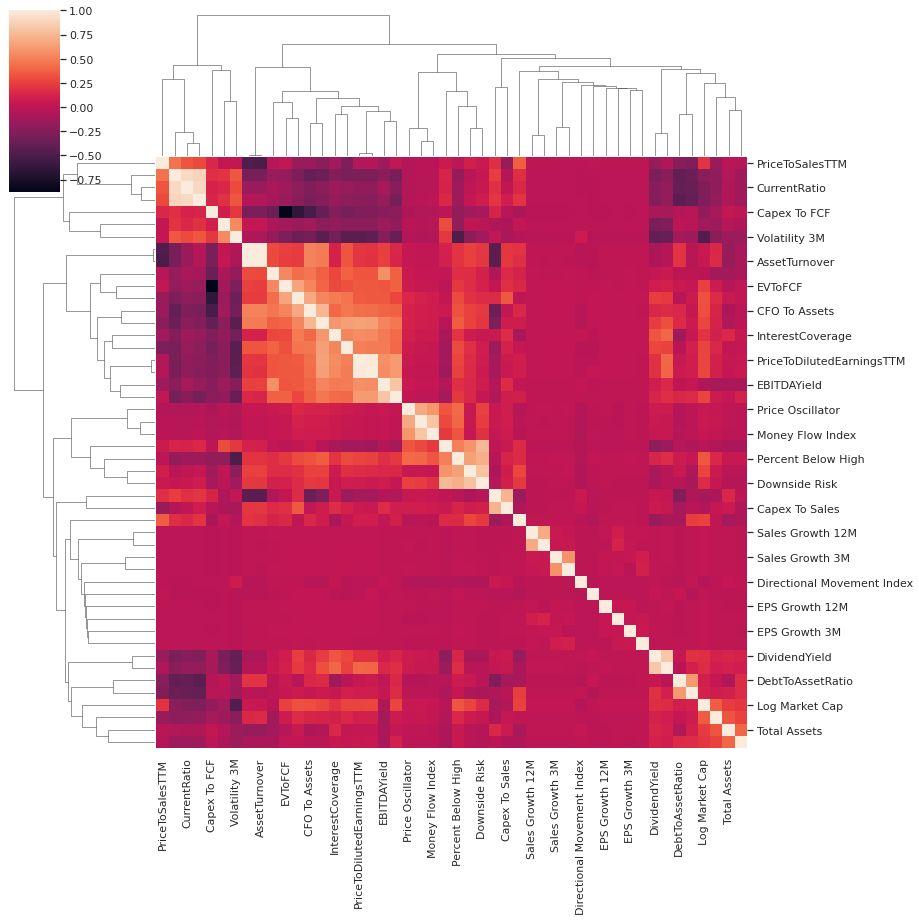

In [42]:
g = sns.clustermap(data.drop(['stock'] + return_cols, axis=1).corr())
plt.gcf().set_size_inches((14,14));

#### Prepare Features

In [43]:
X = pd.get_dummies(data.drop(return_cols, axis=1), drop_first=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92380 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Columns: 2222 entries, DividendYield to stock_ZURN WATER SOLUTIONS CORP
dtypes: float64(48), uint8(2174)
memory usage: 225.7+ MB


#### Shifted Returns

In [44]:
y = data.loc[:, return_cols]
shifted_y = []
for col in y.columns:
    t = int(re.search(r'\d+', col).group(0))
    # print(t)
    shifted_y.append(y.groupby(level='asset')['Returns{}D'.format(t)].shift(-t).to_frame(col))
y = pd.concat(shifted_y, axis=1)
y.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92380 entries, (Timestamp('2023-07-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG000C2V3D6 [A])) to (Timestamp('2023-09-20 00:00:00+0000', tz='UTC', freq='C'), Equity(FIBBG01BPHNXZ3 [BAM]))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Returns1D   90205 non-null  float64
 1   Returns5D   81530 non-null  float64
 2   Returns10D  70746 non-null  float64
 3   Returns20D  49508 non-null  float64
dtypes: float64(4)
memory usage: 3.2+ MB


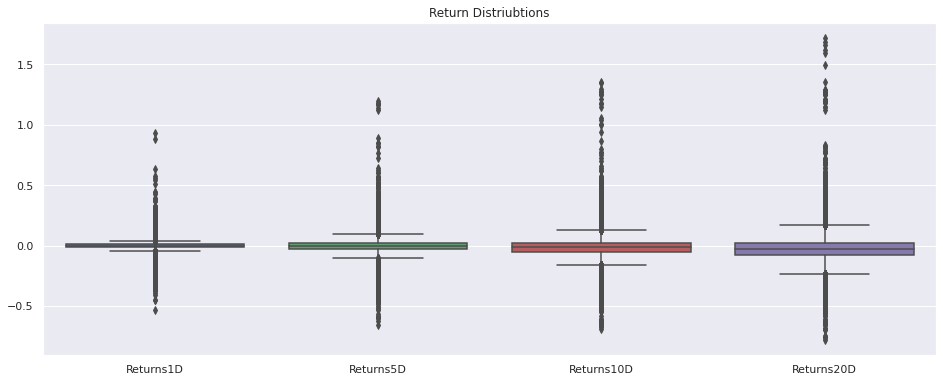

In [45]:
ax = sns.boxplot(data=y[return_cols])
ax.set_title('Return Distriubtions');

### Linear Regression

#### Statsmodels

In [ ]:
target = 'Returns1D'
model_data = pd.concat([y[[target]], X], axis=1).dropna()
model_data = model_data[model_data[target].between(model_data[target].quantile(.025), 
                                                   model_data[target].quantile(.975))]

model = OLS(endog=model_data[target], exog=model_data.drop(target, axis=1))
trained_model = model.fit()
trained_model.summary()

In [ ]:
target = 'Returns5D'
model_data = pd.concat([y[[target]], X], axis=1).dropna()
model_data = model_data[model_data[target].between(model_data[target].quantile(.025), 
                                                   model_data[target].quantile(.975))]

model = OLS(endog=model_data[target], exog=model_data.drop(target, axis=1))
trained_model = model.fit()
trained_model.summary()

In [ ]:
target = 'Returns10D'
model_data = pd.concat([y[[target]], X], axis=1).dropna()
model_data = model_data[model_data[target].between(model_data[target].quantile(.025), 
                                                   model_data[target].quantile(.975))]

model = OLS(endog=model_data[target], exog=model_data.drop(target, axis=1))
trained_model = model.fit()
trained_model.summary()

In [ ]:
target = 'Returns20D'
model_data = pd.concat([y[[target]], X], axis=1).dropna()
model_data = model_data[model_data[target].between(model_data[target].quantile(.025), 
                                                   model_data[target].quantile(.975))]

model = OLS(endog=model_data[target], exog=model_data.drop(target, axis=1))
trained_model = model.fit()
trained_model.summary()

#### sklearn

In [50]:
def time_series_split(d, nfolds=5, min_train=21):
    """Generate train/test dates for nfolds 
    with at least min_train train obs
    """
    train_dates = d[:min_train].tolist()
    n = int(len(dates)/(nfolds + 1)) + 1
    test_folds = [d[i:i + n] for i in range(min_train, len(d), n)]
    for test_dates in test_folds:
        if len(train_dates) > min_train:
            yield train_dates, test_dates
        train_dates.extend(test_dates)

In [51]:
target = 'Returns10D'
outliers = .01
model_data = pd.concat([y[[target]], X], axis=1).dropna().reset_index('asset', drop=True)
model_data = model_data[model_data[target].between(*model_data[target].quantile([outliers, 1-outliers]).values)] 

model_data[target] = np.log1p(model_data[target])
features = model_data.drop(target, axis=1).columns
dates = model_data.index.unique()

print(model_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69330 entries, 2023-07-20 00:00:00+00:00 to 2023-09-06 00:00:00+00:00
Columns: 2223 entries, Returns10D to stock_ZURN WATER SOLUTIONS CORP
dtypes: float64(49), uint8(2174)
memory usage: 172.2 MB
None


In [53]:
model_data[target].describe()

count    69330.000000
mean        -0.018138
std          0.063877
min         -0.265142
25%         -0.052484
50%         -0.014508
75%          0.019778
max          0.175770
Name: Returns10D, dtype: float64

In [54]:
idx = pd.IndexSlice

In [56]:
nfolds = 250
lr = LinearRegression()

test_results, result_idx, preds = [], [], pd.DataFrame()
for train_dates, test_dates in time_series_split(dates, nfolds=nfolds):
    
    X_train = model_data.loc[idx[train_dates], features]
    y_train = model_data.loc[idx[train_dates], target]
    lr.fit(X=X_train, y=y_train)
    
    X_test = model_data.loc[idx[test_dates], features]
    y_test = model_data.loc[idx[test_dates], target]
    y_pred = lr.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    ic, pval = spearmanr(y_pred, y_test)
    
    test_results.append([rmse, ic, pval])
    preds = preds.append(y_test.to_frame('actuals').assign(predicted=y_pred))
    result_idx.append(train_dates[-1])

In [57]:
test_result = pd.DataFrame(test_results, columns=['rmse', 'ic', 'pval'], index=result_idx)

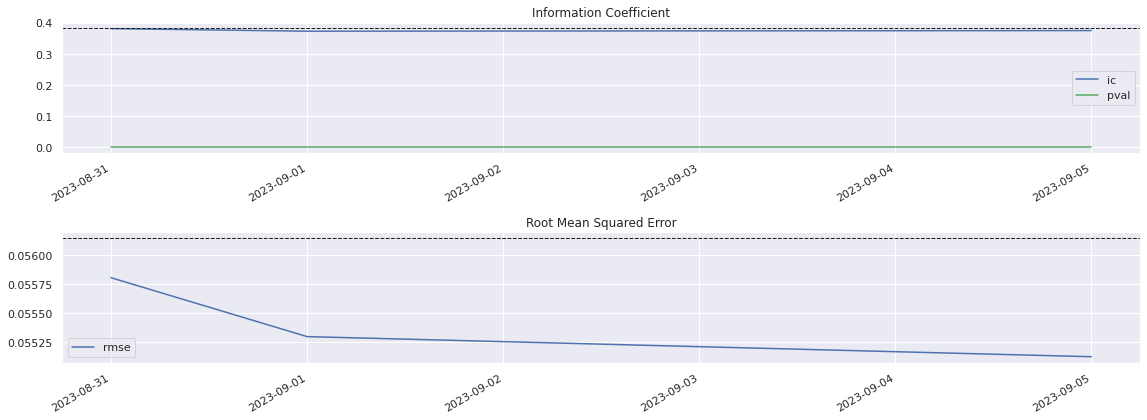

In [64]:
fig, axes = plt.subplots(nrows=2)
rolling_result = test_result.rolling(21).mean()
rolling_result[['ic', 'pval']].plot(ax=axes[0], title='Information Coefficient')
axes[0].axhline(test_result.ic.mean(), lw=1, ls='--', color='k')
rolling_result[['rmse']].plot(ax=axes[1], title='Root Mean Squared Error')
axes[1].axhline(test_result.rmse.mean(), lw=1, ls='--', color='k')
plt.tight_layout();

KeyboardInterrupt: 

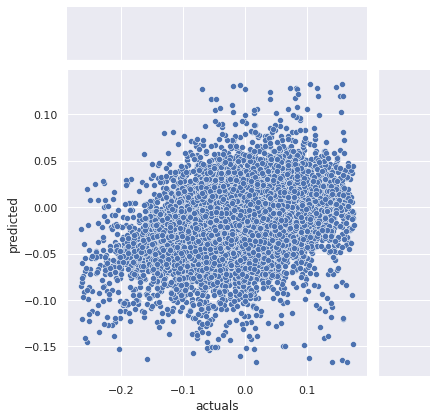

In [68]:
preds_cleaned = preds[(preds.predicted.between(*preds.predicted.quantile([.001, .999]).values))]
g = sns.jointplot(x='actuals', y='predicted', data=preds_cleaned)

# Compute Spearman correlation
corr_value, _ = spearmanr(preds_cleaned['actuals'], preds_cleaned['predicted'])

# Annotate the figure with the computed Spearman correlation
g.ax_joint.annotate(f"Spearman: {corr_value:.2f}", 
                    xy=(0.1, 0.9), 
                    xycoords='axes fraction', 
                    fontsize=12)

plt.show()
# sns.jointplot(x='actuals', y='predicted', data=preds_cleaned, stat_func=spearmanr);

### Ridge Regression: Regularization

In [69]:
nfolds = 250
alphas = np.logspace(-10, 10, 21)
scaler = StandardScaler()

result = pd.DataFrame()
for alpha in alphas:
    test_results = []
    lr_ridge = Ridge(alpha=alpha)
    for train_dates, test_dates in time_series_split(dates, nfolds=nfolds):

        X_train = model_data.loc[idx[train_dates], features]
        y_train = model_data.loc[idx[train_dates], target]
        lr_ridge.fit(X=scaler.fit_transform(X_train), y=y_train)

        X_test = model_data.loc[idx[test_dates], features]
        y_test = model_data.loc[idx[test_dates], target]
        y_pred = lr_ridge.predict(scaler.transform(X_test))

        rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        ic, pval = spearmanr(y_pred, y_test)
        
        test_results.append([train_dates[-1], rmse, ic, pval, alpha])
    result = result.append(pd.DataFrame(test_results, columns=['date', 'rmse', 'ic', 'pval', 'alpha']))

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.40677e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.21206e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.03321e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.86939e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

KeyboardInterrupt: 

In [ ]:
result.describe()

In [ ]:
result.groupby('alpha').mean()

In [ ]:
sns.boxplot(y='ic', x='alpha', data=result);

In [ ]:
ax = result.groupby('alpha')['ic', 'rmse'].mean().plot(logx=True)
ax.axhline(test_result.ic.mean())
ax.axhline(test_result.rmse.mean());

In [ ]:
nfolds = 250
alphas = np.logspace(-5, 5, 11)
scaler = StandardScaler()

result2 = pd.DataFrame()
for alpha in alphas:
    test_results = []
    print(alpha)
    lr_lasso = Lasso(alpha=alpha)
    for i, (train_dates, test_dates) in enumerate(time_series_split(dates, nfolds=nfolds)):
        if i % 50 == 0:
            print('\t{}'.format(i))

        X_train = model_data.loc[idx[train_dates], features]
        y_train = model_data.loc[idx[train_dates], target]
        lr_lasso.fit(X=scaler.fit_transform(X_train), y=y_train)

        X_test = model_data.loc[idx[test_dates], features]
        y_test = model_data.loc[idx[test_dates], target]
        y_pred = lr_lasso.predict(scaler.transform(X_test))

#         mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
        rmse = np.sqrt(np.sum((y_test-y_pred)**2))
        ic, pval = spearmanr(y_pred, y_test)
        
        test_results.append([train_dates[-1], rmse, ic, pval, alpha])
    result2 = result2.append(pd.DataFrame(test_results, columns=['date', 'rmse', 'ic', 'pval', 'alpha']))

In [ ]:
result2.groupby('alpha').mean()

### Logistic Regression: Classification

In [ ]:
target = 'Returns10D'
label = (y[target] > 0).astype(int).to_frame(target)
model_data = pd.concat([label, X], axis=1).dropna().reset_index('asset', drop=True)

features = model_data.drop(target, axis=1).columns
dates = model_data.index.unique()

print(model_data.info())

In [ ]:
nfolds = 250
Cs = np.logspace(-5, 5, 11)
scaler = StandardScaler()

# logistic_result = pd.DataFrame(columns=['date', 'rmse', 'ic', 'pval', 'C'])
logistic_preds = pd.DataFrame(columns=['actuals', 'predicted', 'C'])
for C in Cs:
    result = []
    print(C)
    log_reg = LogisticRegression(C=C)
    for i, (train_dates, test_dates) in enumerate(time_series_split(dates, nfolds=nfolds)):

        X_train = model_data.loc[idx[train_dates], features]
        y_train = model_data.loc[idx[train_dates], target]
        log_reg.fit(X=scaler.fit_transform(X_train), y=y_train)

        X_test = model_data.loc[idx[test_dates], features]
        y_test = model_data.loc[idx[test_dates], target]
        y_pred = log_reg.predict_proba(scaler.transform(X_test))[:, 1]
        
#         rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
#         ic, pval = spearmanr(y_pred, y_test)
        logistic_preds = (logistic_preds
                          .append(y_test
                                  .to_frame('actuals')
                                  .assign(predicted=y_pred, C=C)))
        
#         result.append([train_dates[-1], rmse, ic, pval, alpha])
#     logistic_result = logistic_result.append(pd.DataFrame(result))

In [ ]:
logistic_preds.info()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
auc = logistic_preds.groupby('C').apply(lambda x: roc_auc_score(y_true=x.actuals.astype(int), 
                                                          y_score=x.predicted))
auc

In [ ]:
auc.sort_index(ascending=False).plot(logx=True);

In [ ]:
logistic_preds.info()

### Ordinal Logit

In [ ]:
target = 'Returns10D'
label = (y[target] > 0).astype(int).to_frame(target)
model_data = pd.concat([label, X], axis=1).dropna().reset_index('asset', drop=True)

features = model_data.drop(target, axis=1).columns
dates = model_data.index.unique()

print(model_data.info())

## TA-Lib

In [ ]:
class Technical:
    @staticmethod
    def make_bbands(timeperiod=5, nbdevup=2, nbdevdn=2, matype=0):
        class BBANDS(CustomFactor):
            """Lower, middle, and upper Bollinger Bands"""

            inputs = [EquityPricing.close]
            outputs = ['upper', 'middle', 'lower']
            window_length = timeperiod

            def compute(self, today, assets, out, close_prices):
                bb = []
                for close in close_prices.T:
                    u, m, l = talib.BBANDS(close, timeperiod=timeperiod, 
                                nbdevup=nbdevup, nbdevdn=nbdevdn, 
                                matype=matype)
                    bb.append((u[-1], m[-1], l[-1]))
                out.upper[:], out.middle[:], out.lower[:] = list(zip(*bb))
        return BBANDS
    
    @staticmethod
    def make_ema(timeperiod=30):
        class EMA(CustomFactor):
            """Double Exponential Moving Average"""
            inputs = [EquityPricing.close]
            window_length = timeperiod
            
            def compute(self, today, assets, out, close_prices):
                out[:] = [talib.EMA(p, timeperiod=timeperiod)[-1] for p in close_prices.T]
        return EMA 
    
    @staticmethod
    def make_dx(timeperiod=14):
        class DX(CustomFactor):
            """Directional Movement Index"""
            inputs = [EquityPricing.high, 
                      EquityPricing.low, 
                      EquityPricing.close]
            window_length = timeperiod + 1
            
            def compute(self, today, assets, out, high, low, close):
                out[:] = [talib.DX(high[:, i], 
                                   low[:, i], 
                                   close[:, i], 
                                   timeperiod=timeperiod)[-1] 
                          for i in range(len(assets))]
        return DX  
    
    
    @staticmethod
    def make_mfi(timeperiod=14):
        class MFI(CustomFactor):
            """Money Flow Index"""
            inputs = [EquityPricing.high, 
                      EquityPricing.low, 
                      EquityPricing.close,
                      EquityPricing.volume]
            window_length = timeperiod + 1
            
            def compute(self, today, assets, out, high, low, close, vol):
                out[:] = [talib.MFI(high[:, i], 
                                    low[:, i], 
                                    close[:, i],
                                    vol[:, i],
                                    timeperiod=timeperiod)[-1] 
                          for i in range(len(assets))]
        return MFI     

In [ ]:
def test_pipeline():
    stocks = StaticAssets(symbols(['MSFT', 'AAPL']))
#     DX = Technical.make_dx()
    MFI = Technical.make_mfi()
    
    ewma = EWMA(inputs=[EquityPricing.high],
                        window_length=30, 
                        decay_rate=.2,
                        mask=stocks)
    bb = BollingerBands(window_length=30, k=2, mask=stocks)
    return Pipeline({'adx': Technical.make_dx()(mask=stocks),
                     'mfi': MFI(mask=stocks),
                     'ewma': ewma,
                     'lower': bb.lower,
                     'mid': bb.middle,
                     'up': bb.upper},
                    screen=stocks)

In [ ]:
start_timer = time()
result = run_pipeline(test_pipeline(), 
                      start_date='2018-05-01',
                      end_date='2018-07-31')
print('Pipeline run time {:.2f} secs'.format(time() - start_timer))
result.tail(10)

In [ ]:
def momentum_pipeline_alt():
    ewma = EWMA(inputs=[EquityPricing.high],
                        window_length=30, 
                        decay_rate=.2,
                        mask=UNIVERSE)
    bb = BollingerBands(window_length=30, k=2, mask=UNIVERSE)
    
    STOCH = MomentumFactors.make_stochastic_oscillator()
    spo = STOCH(mask=UNIVERSE)

    columns = {'ewma': ewma,
               'so_slowk': spo.slowk,
               'so_slowd': spo.slowd,
               'bb_lower': bb.lower,
               'bb_mid': bb.middle,
               'bb_up': bb.upper}
    columns.update({k: v(mask=UNIVERSE) for k, v in MOMENTUM_FACTORS.items()})
    
    return Pipeline(columns,
                    screen=UNIVERSE)